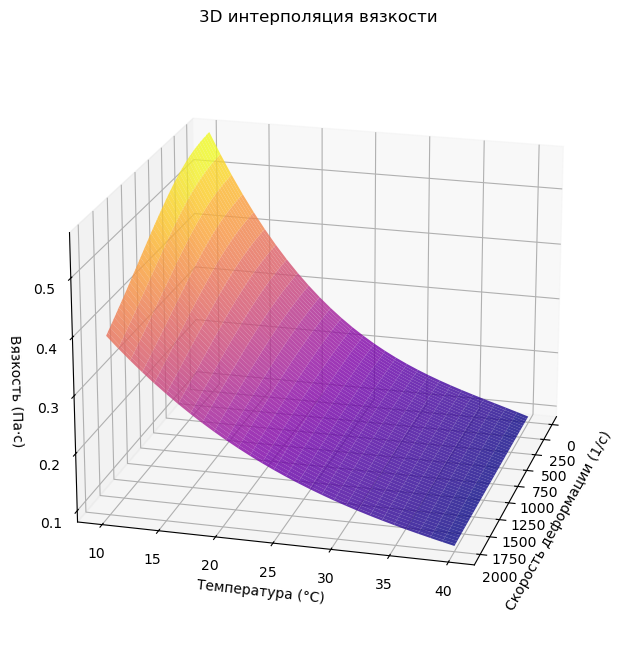

Доступный диапазон температур: 10°C - 40°C


Введите температуру для аппроксимации:  33


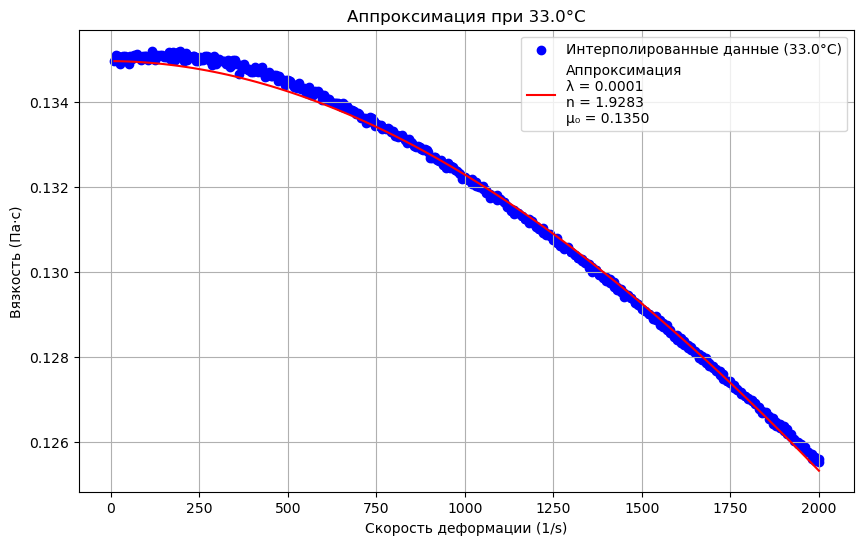

Результаты сохранены в файлы:
- График: viscosity_fit_33.0C.png
- Параметры: fit_params_33.0C.txt


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit
from mpl_toolkits.mplot3d import Axes3D

# Аппроксимационная модель
def viscosity_model(gamma, lam, n, mu0):
    return mu0 / (1 + (lam * gamma)**abs(n))

# Загрузка данных
temp_files = {10: '10_grad.txt', 20: '20_grad.txt', 30: '30_grad.txt', 40: '40_grad.txt'}
temps = np.array(sorted(temp_files.keys()))
data = {}

for T, filename in temp_files.items():
    arr = np.loadtxt(filename)
    data[T] = (arr[:, 0], arr[:, 1])  # (shear_rates, viscosities)


shear_rates = data[temps[0]][0]


# Подготовка матрицы вязкостей
viscosities_matrix = np.array([data[T][1] for T in temps])

# 1. Построение 3D графика интерполяции
interpolated_temps = np.linspace(10, 40, 30)
interpolated_viscosities = np.array([interp1d(temps, viscosities_matrix[:, i], 
                                            kind='cubic')(interpolated_temps) 
                                   for i in range(len(shear_rates))]).T

# Создание сетки
shear_grid, temp_grid = np.meshgrid(shear_rates, interpolated_temps)

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(shear_grid, temp_grid, interpolated_viscosities, 
               cmap='plasma', alpha=0.8)
ax.view_init(elev=20, azim=15)
ax.set_xlabel('Скорость деформации (1/c)')
ax.set_ylabel('Температура (°C)')
ax.set_zlabel('Вязкость (Па·с)')
plt.title('3D интерполяция вязкости')
plt.savefig('viscosity_3d_interpolation.png', dpi=300)
plt.show()

# 2. Аппроксимация для заданной температуры
print(f"Доступный диапазон температур: {temps.min()}°C - {temps.max()}°C")
while True:
    try:
        target_temp = float(input("Введите температуру для аппроксимации: "))
        if temps.min() <= target_temp <= temps.max():
            break
        print(f"Температура должна быть между {temps.min()} и {temps.max()}°C")
    except ValueError:
        print("введите число")

# Интерполяция данных для заданной температуры
interp_visc = np.array([interp1d(temps, viscosities_matrix[:, i], 
                       kind='cubic')(target_temp) 
                      for i in range(len(shear_rates))])

# Начальные параметры для аппроксимации
mu0 = interp_visc[0]  # Вязкость при минимальной скорости деформации
initial_guess = [1.0, 1.0]  # Начальные значения для lambda и n

# Выполнение аппроксимации
try:
    popt, pcov = curve_fit(lambda gamma, lam, n: viscosity_model(gamma, lam, n, mu0),
                          shear_rates, interp_visc,
                          p0=initial_guess,
                          bounds=([0, 0], [np.inf, np.inf]))
    
    lam_opt, n_opt = popt
    
    #  отображение
    shear_smooth = np.linspace(min(shear_rates), max(shear_rates), 100)
    visc_fit = viscosity_model(shear_smooth, lam_opt, n_opt, mu0)
    
    # Построение графика аппроксимации
    plt.figure(figsize=(10, 6))
    plt.scatter(shear_rates, interp_visc, color='blue', 
               label=f'Интерполированные данные ({target_temp}°C)')
    plt.plot(shear_smooth, visc_fit, 'r-', 
            label=f'Аппроксимация\nλ = {lam_opt:.4f}\nn = {n_opt:.4f}\nμ₀ = {mu0:.4f}')
    
    plt.xlabel('Скорость деформации (1/s)')
    plt.ylabel('Вязкость (Па·с)')
    plt.title(f'Аппроксимация при {target_temp}°C')
    plt.legend()
    plt.grid(True)
    plt.savefig(f'viscosity_fit_{target_temp}C.png', dpi=300)
    plt.show()
    
    # Сохранение параметров в файл
    with open(f'fit_params_{target_temp}C.txt', 'w') as f:
        f.write(f"Параметры аппроксимации при {target_temp}°C:\n")
        f.write(f"lambda: {lam_opt}\n")
        f.write(f"n: {n_opt}\n")
        f.write(f"mu0: {mu0}\n")
    
    print(f"Результаты сохранены в файлы:")
    print(f"- График: viscosity_fit_{target_temp}C.png")
    print(f"- Параметры: fit_params_{target_temp}C.txt")

except Exception as e:
    print(f"Ошибка при аппроксимации: {e}")